In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

MAZE_FILE_NAME = "../Maze.png"
ROBOT_FILE_NAME = "../Robot.png"
IMAGE_LADYBUG_FILE_NAME = "../Ladybug_small.png"
MAP_FILE_NAME = "../MapBuilt.txt"

TRANSFORMED_MAZE = None

ROWS = 5
COLUMNS = 9

def showMaze(image):
    plt.figure(figsize = (COLUMNS,ROWS))
    plt.imshow(image)
    plt.show()
    
def transformImage(cX, cY, corners, image):
    centres = [[0, 0], [0, 0], [0, 0], [cX, cY]]

    for c in corners:
        if cX >= 0 and cX <= 337.5:
            # PINK in top left
            if cY >= 0 and cY <= 375:
                # Same X
                if c[0] >= 0 and c[0] <= 337.5:
                    centres[2] = c
                # Same Y
                elif c[1] >= 0 and c[1] <= 375:
                    centres[1] = c
                else:
                    centres[0] = c
            # PINK in bottom left 
            else:
                # Same X
                if c[0] >= 0 and c[0] <= 337.5:
                    centres[2] = c
                # Same Y
                elif c[1] >= 375 and c[1] <= 750:
                    centres[1] = c
                else:
                    centres[0] = c
        else:
            # PINK in top right
            if cY >= 0 and cY <= 375:
                # Same X
                if c[0] >= 1012.5 and c[0] <= 1350:
                    centres[2] = c
                # Same Y
                elif c[1] >= 0 and c[1] <= 375:
                    centres[1] = c
                else:
                    centres[0] = c
            # PINK in bottom right 
            else:
                # Same X
                if c[0] >= 1012.5 and c[0] <= 1350:
                    centres[2] = c
                # Same Y
                elif c[1] >= 375 and c[1] <= 750:
                    centres[1] = c
                else:
                    centres[0] = c

    pts1 = np.float32(centres)
    pts2 = np.float32([[0,0],[0,500],[900,0],[900,500]])

    H = cv2.getPerspectiveTransform(pts1, pts2)
    maze = cv2.warpPerspective(image, H, (900,500))
    return H, maze

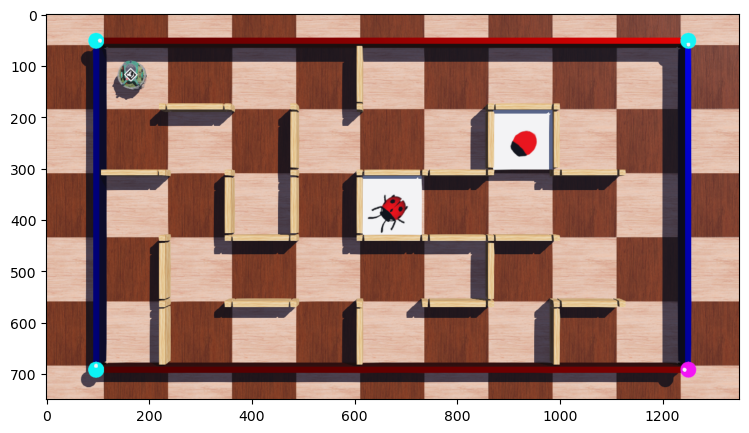

In [2]:
# PRINT OUT MAZE IN RGB
mazeImage = cv2.imread(MAZE_FILE_NAME)

imageRGB = cv2.cvtColor(mazeImage,cv2.COLOR_BGR2RGB)

showMaze(imageRGB)

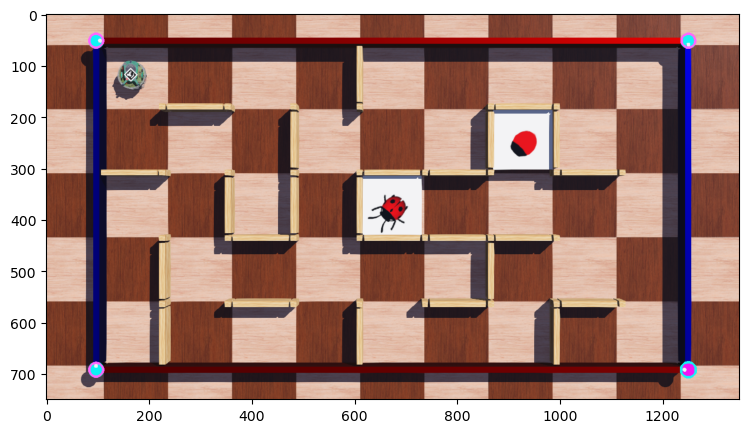

In [3]:
# IDENTIFY CORNERSTONES
imageHSV = cv2.cvtColor(mazeImage,cv2.COLOR_BGR2HSV)

lowerBlue = np.array([25, 0, 234], dtype="uint8")
upperBlue = np.array([100, 255, 255], dtype="uint8")
maskBlue = cv2.inRange(imageHSV, lowerBlue, upperBlue)

lowerPink = np.array([150, 0, 240], dtype="uint8")
upperPink = np.array([150, 240, 255], dtype="uint8")
maskPink = cv2.inRange(imageHSV, lowerPink, upperPink)

k = np.ones((3,3),np.uint8)
maskB = cv2.erode(maskBlue,k,iterations=1)
blueContours = cv2.findContours(maskB, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blueContours = blueContours[0] if len(blueContours) == 2 else blueContours[1]

corners = []

for c in blueContours:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(approx) > 5:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            corners.append([cX, cY])
            cv2.drawContours(imageRGB, [c], -1, (255, 102, 255), 3)
        
pinkContours = cv2.findContours(maskPink, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pinkContours = pinkContours[0] if len(pinkContours) == 2 else pinkContours[1]

for c in pinkContours:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(approx) > 5:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.drawContours(imageRGB, [c], -1, (21,243,245), 3)        
        
showMaze(imageRGB)

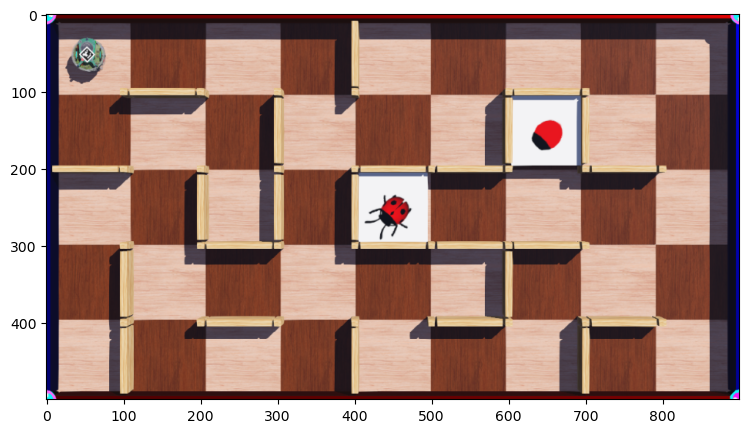

In [4]:
# PERSPECTIVE TRANSFORM
_, TRANSFORMED_MAZE = transformImage(cX, cY, corners, imageRGB)
showMaze(TRANSFORMED_MAZE)

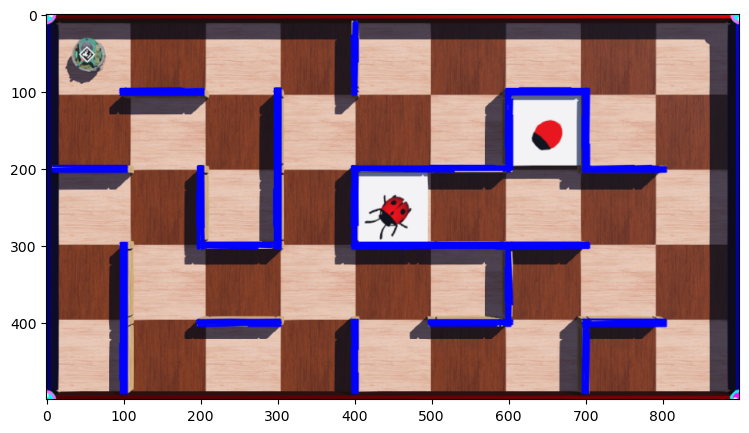

In [5]:
# DETECT INTERNAL WALLS
lower = np.array([17, 0, 221])
upper = np.array([19, 255, 255])
mask = cv2.inRange(imageHSV, lower, upper)

walls = cv2.HoughLinesP(mask, 1, np.pi / 180, 50, None, 10, 10)

if walls is not None:
    for i in range(0, len(walls)):
        lin = walls[i][0]
        cv2.line(imageRGB, (lin[0], lin[1]), (lin[2], lin[3]), (0,0,255), 2, cv2.LINE_AA)

H, TRANSFORMED_MAZE = transformImage(cX, cY, corners, imageRGB)
showMaze(TRANSFORMED_MAZE)

MDiffx:  1.0
MDiffy:  143.0


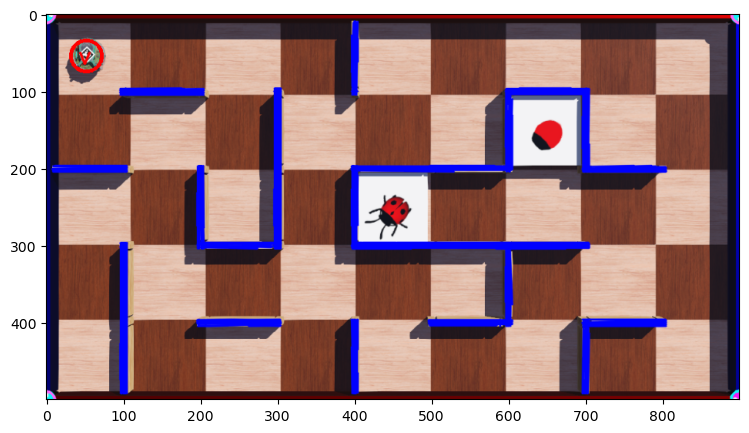

In [6]:
# LOCATION AND HEADING OF ROBOT
maze = TRANSFORMED_MAZE
mazeHSV = cv2.cvtColor(maze, cv2.COLOR_RGB2HSV)
robotImage = cv2.imread(ROBOT_FILE_NAME)

lowerBot = np.array([35, 10, 70])
upperBot = np.array([100, 117, 164])
maskBot = cv2.inRange(mazeHSV, lowerBot, upperBot)

mask = cv2.erode(maskBot,k,iterations=1)
mask = cv2.dilate(mask,k,iterations=15)

_, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i, c in enumerate(contours):
    M = cv2.moments(c)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

robotMaze = cv2.circle(maze, (cx, cy), 20, (255,0,0), 3)

robotImageRGB = cv2.cvtColor(robotImage, cv2.COLOR_BGR2RGB)

dst = cv2.warpPerspective(robotImageRGB, H, (1800,1000))

# Code borrowed from https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics_video.html
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
parameters =  cv2.aruco.DetectorParameters_create()
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(dst, dictionary, parameters=parameters)
# End of code borrowed
if not markerCorners:
    dstHSV = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)
    maskDST = cv2.inRange(dstHSV, lowerBot, upperBot)
    maskDST = cv2.dilate(maskDST,k,iterations=100)

    _, contours, _ = cv2.findContours(maskDST, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i, c in enumerate(contours):
        M = cv2.moments(c)
        dstCx = int(M['m10']/M['m00'])
        dstCy = int(M['m01']/M['m00'])
        
    # Code borrowed from https://pyimagesearch.com/2021/02/03/opencv-image-translation/
    # changed to translate image so that the marker on the robot can be seen
    if dstCx < 450:
        # top left
        if dstCy < 450:
            M = np.float32([[1, 0, 900], [0, 1, 450]])
        #bottom left
        else:
            M = np.float32([[1, 0, 900], [0, 1, -450]])
    elif dstCx > 1350:
        # top right
        if dstCy < 450:
            M = np.float32([[1, 0, -900], [0, 1, 450]])
        # bottom right
        else:
            M = np.float32([[1, 0, -1000], [0, 1, -450]])
    else:
        # top
        if dstCy < 450:
            M = np.float32([[1, 0, 0], [0, 1, -225]])
        # bottom
        else:
            M = np.float32([[1, 0, 0], [0, 1, 225]])
    shifted = cv2.warpAffine(robotImageRGB, M, (dst.shape[1], dst.shape[0]))
    dst = cv2.warpPerspective(shifted, H, (1800,1000))
    # End of code borrowed
    markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(dst, dictionary, parameters=parameters)

MDiffx = markerCorners[0][0][0][0]-markerCorners[0][0][2][0]
MDiffy = markerCorners[0][0][0][1]-markerCorners[0][0][2][1]
print("MDiffx: ", MDiffx)
print("MDiffy: ", MDiffy)
if MDiffx < -30:
    heading = '<'
elif MDiffx < 0:
    if MDiffy < 0:
        heading = '^'
    else:
        heading = 'v'
elif MDiffx < 30:
    if MDiffy > 0:
        heading = 'v'
    else:
        heading = '^'
else:
    heading = '>'
    
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(robotMaze, heading, (cx-10,cy+10), font, 1, (255,0,0), 2, cv2.LINE_AA)

showMaze(robotMaze)

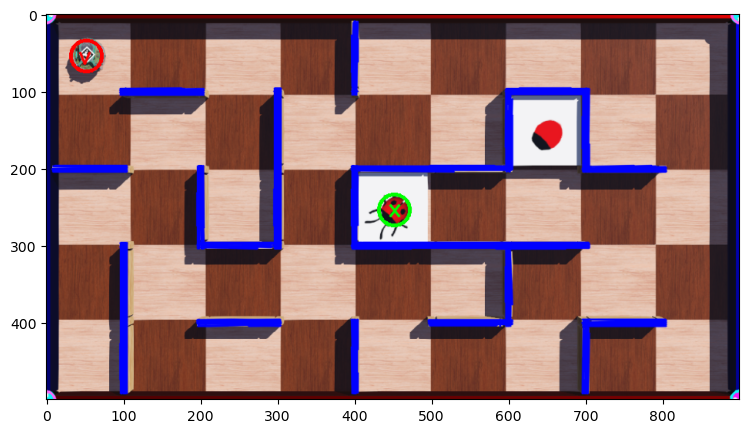

In [7]:
# TARGET LOCATION
mazeHSV = cv2.cvtColor(TRANSFORMED_MAZE, cv2.COLOR_RGB2HSV)
bugImage = cv2.imread(IMAGE_LADYBUG_FILE_NAME)

lowerBug = np.array([150,180,160])
upperBug = np.array([179,250,230])
maskBug = cv2.inRange(mazeHSV, lowerBug, upperBug)

mask=cv2.erode(maskBug,k,iterations=2)
mask=cv2.dilate(mask,k,iterations=12)

_, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i, c in enumerate(contours):
    M = cv2.moments(c)
    cxBug = int(M['m10']/M['m00'])
    cyBug = int(M['m01']/M['m00'])

bugMaze = cv2.circle(maze, (cxBug, cyBug), 20, (0,255,0), 3)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(bugMaze, 'x', (cxBug-8,cyBug+8), font, 1, (0,255,0), 2, cv2.LINE_AA)

showMaze(bugMaze)

In [8]:
wallCheck = list(range(70,131))
row = list(range(0,401,100))
column = list(range(0,801,100))

finalMazeRGB = cv2.cvtColor(bugMaze,cv2.COLOR_RGB2HSV) 
lower = np.array([120, 255, 255])
upper = np.array([120, 255, 255])
finalMaze = cv2.inRange(finalMazeRGB, lower, upper)

f = open(MAP_FILE_NAME, "w")
f.write(" --- --- --- --- --- --- --- --- --- ")

for i in row:
    f.write("\n")
    f.write("|") 
    for j in column:
        if cx in range(j,j+100) and cy in range(i,i+100):
            f.write(" ")
            f.write(heading)
            f.write(" ")
        elif cxBug in range(j,j+100) and cyBug in range(i,i+100):
            f.write(" x ")
        else:
            f.write("   ")
        if j == 800:
            f.write("|")
        else:
            for k in wallCheck:
                if finalMaze[i+50,j+k] == 255:
                    d = True
                    break
                else:
                    d = False
            if d == True:
                f.write("|")
            else:
                f.write(" ")
    f.write("\n")
    if i == 400:
        break
    f.write(" ")
    for j in column:
        for k in wallCheck:
            if finalMaze[i+k,j+50] == 255:
                d = True
                break
            else:
                d = False
        if d == True:
            f.write("--- ")
        else:
            f.write("    ")
f.write(" --- --- --- --- --- --- --- --- --- \n")
f.close()